In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

from glio.data.DS import DSToTarget
from glio.datasets import LUMIERE
from glio import nn as gnn
from glio.nn import conv, convt, linear
from glio.torch_tools import summary, lr_finder
from glio.jupyter_tools import clean_mem, show_slices, show_slices_arr
from glio.loaders import nifti
from glio.train import *
from glio.points import Point, BoundingBox, draw_point, draw_bbox, bbox_from_xxdd as xxdd

In [2]:
lum = LUMIERE.LUMIERE()
print(lum.col_names())

['Patient', 'Survival time (weeks)', 'Sex', 'Age at surgery (years)', 'IDH (WT: wild type)', 'IDH method', 'MGMT qualitative', 'MGMT quantitative', 'Date', 'LessThan3Months', 'NonMeasurableLesions', 'RANO', 'bbox', 'CT1 image', 'CT1 mask', 'CT1 necrosis bbox', 'CT1 hga-image', 'CT1 hga-mask', 'CT1 hga-non-enhancing bbox', 'CT1 hga-contrast-enhancing bbox', 'T1 hga-image', 'T1 hga-mask', 'T1 hga-non-enhancing bbox', 'T1 hga-contrast-enhancing bbox', 'T2 hga-image', 'T2 hga-mask', 'T2 hga-non-enhancing bbox', 'T2 hga-contrast-enhancing bbox', 'FLAIR hga-image', 'FLAIR hga-mask', 'FLAIR hga-non-enhancing bbox', 'FLAIR hga-contrast-enhancing bbox', 'CT1 contrast-enhancing bbox', 'CT1 edema bbox', 'T1 image', 'T1 mask', 'T1 necrosis bbox', 'T1 contrast-enhancing bbox', 'T1 edema bbox', 'T2 image', 'T2 mask', 'T2 necrosis bbox', 'T2 contrast-enhancing bbox', 'T2 edema bbox', 'FLAIR image', 'FLAIR mask', 'FLAIR necrosis bbox', 'FLAIR contrast-enhancing bbox', 'FLAIR edema bbox']


In [3]:
d = lum.get_cols(["T1 image", "T1 mask", "FLAIR image", "T1 contrast-enhancing bbox"])

Чёрную область вокруг изображения можно удалить `[25:-25,25:-35,20:-20]`.

Получаем `132, 158, 142`

Визуализация среза с рамкой:

In [4]:
n = 1
slices = [slice(25,-25),slice(25,-35),slice(20,-20)]
ch_slices = [slice(None), slice(25,-25),slice(25,-35),slice(20,-20)]
show_slices_arr(draw_bbox(nifti.read(d[n]["FLAIR image"]), d[n]["T1 contrast-enhancing bbox"], 0)[ch_slices])

interactive(children=(Checkbox(value=False, description='color'), Text(value='0 1 2 3', description='permute')…

<function glio.jupyter_tools.show_slices_arr.<locals>.f(color, permute: str, **kwargs)>

Чтобы обрезать координаты рамки вместе с изображением, используется `bbox.crop`

In [5]:
show_slices_arr(
    draw_bbox(
        nifti.read(d[n]["FLAIR image"])[slices],
        xxdd(d[n]["T1 contrast-enhancing bbox"]).crop(slices),
        0,
    )
)

interactive(children=(Checkbox(value=False, description='color'), Text(value='0 1 2 3', description='permute')…

<function glio.jupyter_tools.show_slices_arr.<locals>.f(color, permute: str, **kwargs)>

In [6]:
img = nifti.read(d[n]["FLAIR image"])[slices]
center = xxdd(d[n]["T1 contrast-enhancing bbox"]).crop(slices).center()
img = center.draw(img, size=10)
show_slices_arr(img)

interactive(children=(Checkbox(value=False, description='color'), Text(value='0 1 2 3', description='permute')…

<function glio.jupyter_tools.show_slices_arr.<locals>.f(color, permute: str, **kwargs)>

## Загрузчик
Загрузчик возращает `[T1, FLAIR, Mask, BBox]`.

Трансформация берёт случайный горизонтальный срез, далее вход и таргет - это изображение и маска

```py
mean_std = ([7.3567939758e+01, 5.9002014160e+01, 2.4059068412e-02], [161.2564239502, 129.0489959717, 0.2359057516])
```

In [7]:
# d = lum.get_cols(["T1 image", "T1 mask", "FLAIR image", "T1 contrast-enhancing bbox"])
import random
from torchvision.transforms import v2
mean_std = ((7.3567939758e+01, 5.9002014160e+01, 2.4059068412e-02), (161.2564239502, 129.0489959717, 0.2359057516),)
norm = v2.Normalize(*mean_std)
def loader(x: dict):
    img3d = torch.stack((nifti.read(x["T1 image"]), nifti.read(x["FLAIR image"]), nifti.read(x["T1 mask"])))[:,*slices].permute(0,3,2,1)
    return img3d, xxdd(x["T1 contrast-enhancing bbox"], img3d.shape[1:]).permute(2,1,0)
    #bbox = x["T1 contrast-enhancing bbox"]

def transform_init(x: tuple[torch.Tensor, BoundingBox]):
    slc = random.randrange(0, x[0].size(1))
    return norm(x[0][:, slc]), x[1].slice(slc, slc + 1, 0).squeeze(0)
def transform_sample(x: tuple[torch.Tensor, BoundingBox]):
    return x[0][:2]
def transform_target(x: tuple[torch.Tensor, BoundingBox]):
    return x[0][2], x[1].to_rel().xyxy()

ds = DSToTarget()
ds.add_samples(d, loader, transform_init, transform_sample, transform_target)
print(len(ds))
# mean_std = ds_norm.get_mean_std(1000, 8)
mean_std

572


((73.567939758, 59.00201416, 0.024059068412),
 (161.2564239502, 129.0489959717, 0.2359057516))

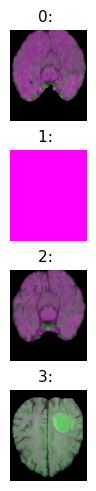

In [8]:
ds.preview(4)

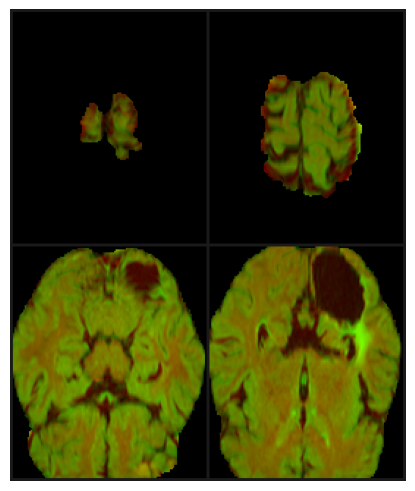

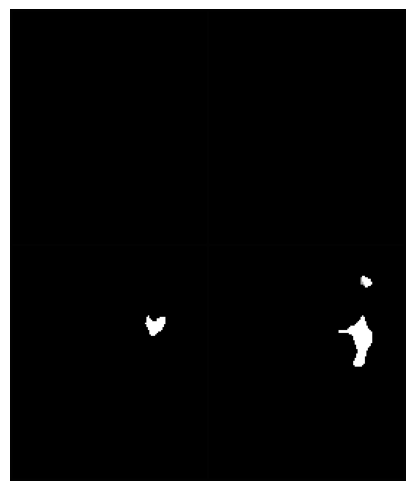

(torch.Size([16, 2, 158, 132]),
 torch.Size([16, 158, 132]),
 tensor(0.5046),
 tensor(0.9944),
 tensor(0.3524),
 tensor(2.2273))

In [9]:
from torch.utils.data import DataLoader
from glio.visualize import vis_imshow_grid
batch = next(iter(DataLoader(ds.cache_repeat_iterator(8, 1), batch_size=16)))
vis_imshow_grid(batch[0])
vis_imshow_grid(batch[1][0], 'bhw')
batch[0].shape, batch[1][0].shape, batch[0].mean(), batch[0].std(), batch[1][0].mean(), batch[1][0].std()

In [10]:
batch[1][0].shape

torch.Size([16, 158, 132])

## Модель

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import ops

from glio import nn as gnn
from glio.nn import conv, convt, linear
from glio.torch_tools import summary, lr_finder
from glio.train import *

In [12]:
class CNN_Base(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = conv(2, 16, 4, 2, bias=False, batch_norm=True, dropout=0.4, act=nn.GELU())
        self.conv2 = conv(16, 32, 3, 2, bias=False, batch_norm=True, dropout=0.5, act=nn.GELU())
        self.conv3 = conv(32, 48, 2, 2, bias=False, batch_norm=True, dropout=0.6, act=nn.GELU())
        self.conv4 = conv(48, 64, 2, 2, bias=False, batch_norm=True, dropout=0.7, act=nn.GELU())
        self.conv5 = conv(64, 64, 2, 2, bias=False, batch_norm=True, dropout=0.75, act=nn.GELU())
        self.convt1 = convt(64, 64, (3,2), 2, bias=False, batch_norm=True, dropout=0.75, act=nn.GELU())
        self.convt2 = convt(64, 48, (3,2), 2, bias=False, batch_norm=True, dropout=0.75, act=nn.GELU())
        self.convt3 = convt(48, 32, (3, 2), 2, bias=False, batch_norm=True, dropout=0.75, act=nn.GELU())
        self.convt4 = convt(32, 16, (4, 3), 2, bias=False, batch_norm=True, dropout=0.75, act=nn.GELU())
        self.convt5 = convt(16, 1, (5, 4), 2, dropout=0.75)
    def forward(self, x:torch.Tensor):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.convt1(x)
        x = self.convt2(x)
        x = self.convt3(x)
        x = self.convt4(x)
        x = self.convt5(x)
        return x[:,0,:158]
    
summary(CNN_Base().to("cuda"), (16, 2, 158, 132))

path                                         module                                       input size               output size              params    buffers   
__main__.CNN_Base/conv1/0                    torch.nn.modules.conv.Conv2d                 (16, 2, 158, 132)        (16, 16, 78, 65)         512       0         
__main__.CNN_Base/conv1/1                    torch.nn.modules.activation.GELU             (16, 16, 78, 65)         (16, 16, 78, 65)         0         0         
__main__.CNN_Base/conv1/2                    torch.nn.modules.batchnorm.BatchNorm2d       (16, 16, 78, 65)         (16, 16, 78, 65)         32        33        
__main__.CNN_Base/conv1/3                    torch.nn.modules.dropout.Dropout2d           (16, 16, 78, 65)         (16, 16, 78, 65)         0         0         
__main__.CNN_Base/conv2/0                    torch.nn.modules.conv.Conv2d                 (16, 16, 78, 65)         (16, 32, 38, 32)         4608      0         
__main__.CNN_Base/conv2/1         

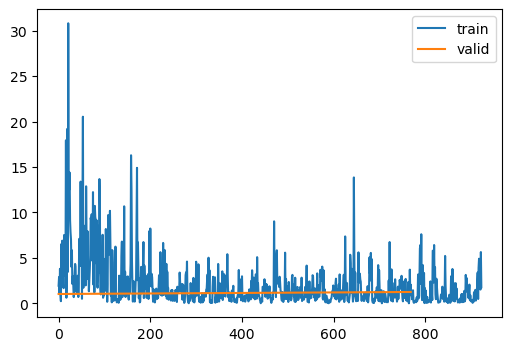

Keyboard interrupt, stopping the training...


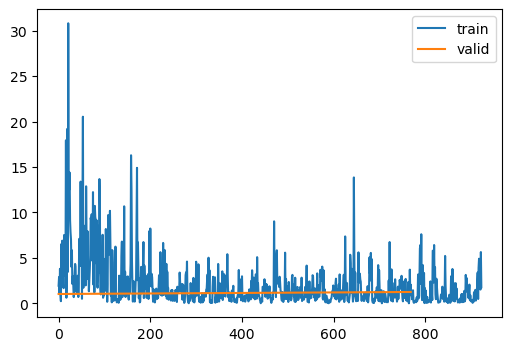

In [14]:
clean_mem()
lr = 1e-2
batch_size = 16
cache_elems = 4
cache_times = 96
n_epochs = 3
split = 0.9

ds_train, ds_test = ds.split(0.9)
dl_train = DataLoader(ds_train.cache_repeat_iterator(cache_times, cache_elems), batch_size)
dl_test = DataLoader(ds_test.cache_repeat_iterator(64, 1), batch_size)
model = CNN_Base()
#model = gnn.LSUV(CNN_Base(), dl)
opt = optim.AdamW(model.parameters(), lr=lr)
sched = optim.lr_scheduler.OneCycleLR(opt, max_lr=lr, steps_per_epoch=len(dl_train), epochs=n_epochs)
def loss_fn(x, y):
    return F.mse_loss(x, y[0]) * (y[0] + 0.1020).mean()
learner = Learner(model, "LUMIERE1 CNNBase",
                  cbs = [Metric_Loss(), Accelerate("no"), FastProgressBar(plot=True, step_batch=64), Log_SignalHistorgram(64)],
                  loss_fn=loss_fn,
                  optimizer=opt,
                  scheduler=sched)
learner.fit(n_epochs, dl_train, dl_test)

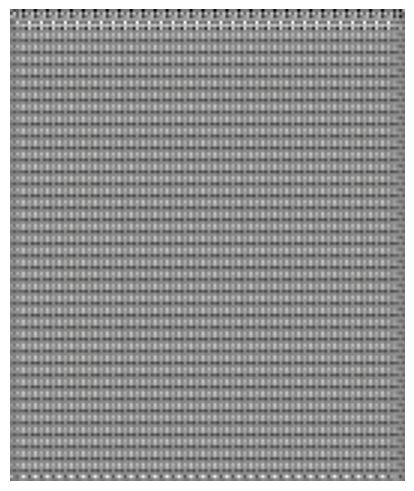

In [20]:
from glio.visualize import vis_imshow
vis_imshow(learner.inference(batch[0]))